**IMPORTANT:** 

**This notebook is a template, and you cannot edit it. To write your own PA, download as .ipynb (File -> download as .ipynb) and upload it to your own Google Colab.**

You should run this using a GPU! In Colab, go to the "runtime" menu, choose "change runtime type", and select "GPU" from the hardware accelerator dropdown menu. Otherwise, this might take much longer. With the GPU, it should run in about 20 minutes or less.

There are **7** places you need to write code in this notebook, for questions **1, 2a, 2b, 3a, 3b, 4a, 4b**, for a total of 60 points.

To turn in this homework: download as .ipynb (File -> download as .ipynb). Make the filename YOURNAME_HW2.ipynb and upload to Gradescope. The assignment due on November 11th at 11:59PM.

Be aware: this assignment may require up to **3 hours** of computation for testing different parameters even when
everything is implemented correctly.

Please read the comments and explanation code carefully. In particular, you may want to study the provided implementation of SGD to get an idea of how the pytorch optimizer class works.

Cell outputs are provided. If you implement your code correctly, you should expect your outputs to be similar to the provided outputs.

In [1]:
# Clone attention modeling and training code needed for question 3
!git clone https://github.com/optmlclass/PA2.git

# get harry potter data (also for question 3)
# !wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
!wget "https://raw.githubusercontent.com/amephraim/nlp/master/texts/J.%20K.%20Rowling%20-%20Harry%20Potter%201%20-%20Sorcerer's%20Stone.txt"
!wget "https://raw.githubusercontent.com/amephraim/nlp/master/texts/J.%20K.%20Rowling%20-%20Harry%20Potter%202%20-%20The%20Chamber%20Of%20Secrets.txt"
!wget "https://raw.githubusercontent.com/amephraim/nlp/master/texts/J.%20K.%20Rowling%20-%20Harry%20Potter%203%20-%20Prisoner%20of%20Azkaban.txt"
!wget "https://raw.githubusercontent.com/amephraim/nlp/master/texts/J.%20K.%20Rowling%20-%20Harry%20Potter%204%20-%20The%20Goblet%20of%20Fire.txt"

Cloning into 'PA2'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 24 (delta 11), reused 16 (delta 5), pack-reused 0
Unpacking objects: 100% (24/24), done.
--2022-11-12 05:04:11--  https://raw.githubusercontent.com/amephraim/nlp/master/texts/J.%20K.%20Rowling%20-%20Harry%20Potter%201%20-%20Sorcerer's%20Stone.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 439742 (429K) [text/plain]
Saving to: ‘J. K. Rowling - Harry Potter 1 - Sorcerer's Stone.txt’

J. K. Rowling - Har 100%[===================>] 429.44K  --.-KB/s    in 0.006s  

2022-11-12 05:04:11 (70.8 MB/s) - ‘J. K. Rowling - Harry Potter 1 - Sorcerer's Stone.txt’ saved [439742/439742]

--2022-11-12 0

In [2]:
import torch, torchvision
import torchvision.transforms as transforms
from torch.optim import Optimizer
import math
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
from collections.abc import Iterable

# set up logging
import logging
logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO,
)

# make deterministic
from PA2.sequenceutils import set_seed
set_seed(42)

# imports for attention model
# more imports
from PA2.attentionmodel import GPT, GPTConfig
from PA2.sequenceutils import sample, CharDataset
from PA2.attentiontrainer import Trainer, TrainerConfig

# Warmup: Standard SGD

## SGD Implementation

In [ ]:
# Basic SGD implementation for reference.
# for base class, see https://github.com/pytorch/pytorch/blob/master/torch/optim/optimizer.py
# for official pytorch SGD implementation, see https://github.com/pytorch/pytorch/blob/master/torch/optim/sgd.py

class SGD(Optimizer):
  def __init__(self, params, lr=1.0):
    super(SGD, self).__init__(params, {'lr': lr})

    # The params argument can be a list of pytorch variables, or
    # a list of dicts. If it is a list of dicts, each dict should have 
    # a key 'params' that is a list of pytorch variables,
    # and optionally another key 'lr' that specifies the learning rate
    # for those variables. If 'lr' is not provided, the default value
    # is the single value provided as an argument after params to this
    # constructor.
    # If params is just a list of pytorch variables, it is the same
    # as if params were actually a list containing a single dictionary
    # whose 'params' key value is the list of variables.
    # See examples in following code blocks for use of params.

    # Set up an iteration counter.
    # self.state[p] is a python dict for each parameter p
    # that can be used to store various state useful in the optimization
    # algorithm. In this case, we simply store the iteration count, although
    # it is not used in this simple algorithm.
    for group in self.param_groups:
      for p in group['params']:
        state = self.state[p]
        state['step'] = 0


  @torch.no_grad()
  def step(self, closure=None):
    loss = None
    # 'closure' is None for all optimizers we are going to implement in this assignment.
    if closure is not None:
      with torch.enable_grad():
        loss = closure()

    for group in self.param_groups:
      lr = group['lr']

      # it is common practice to call the model parameters p in code.
      # in class we follow more closely analytical conventions, in which the
      # parameters are often called w for weights.
      for p in group['params']:
        if p.grad is None:
          continue
        
        # Update the iteration counter (again, this is not actually used in this algorithm)
        state = self.state[p]
        step = state['step']
        step += 1
        
        # Perform the SGD update. p.grad holds the gradient of the loss
        # with respect to p.
        p.add_(p.grad, alpha=-lr)

## Training Loop

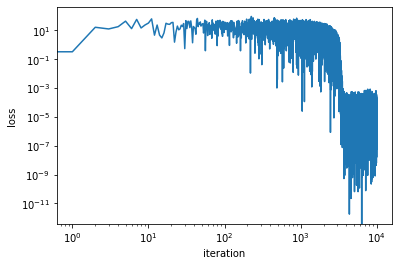

In [ ]:
#Simple linear regression problem
dimension = 10
num_iter = 10000

mean = torch.zeros(dimension)
std = torch.ones(dimension)

def loss_func(w_hat, b_hat, w_true, b_true):
  # simple linear regression problem, although
  # slightly non-standard loss. See pytorch docs
  # for description of loss function.

  # features
  x = torch.normal(mean, std)

  # true label is a linear function of features plus noise.
  noise = np.random.normal(0.0, 0.01)
  y_true = torch.dot(x, w_true) + b_true + noise

  y_hat = torch.dot(x, w_hat) + b_hat

  loss = torch.nn.SmoothL1Loss()
  return loss(y_hat, y_true)


# Set "true" parameter value to be a random normal vector with covariance 10*I
w_true = 10*torch.normal(mean, std)

# make true bias term quite large so that it is better
# to have a high learning rate for the bias. This makes
# it advantageous to use the params as a dict in the 
# following cell.
b_true = torch.normal(torch.zeros(1), torch.ones(1))


# declare variables that will actually be trained.
# "requires_grad" tells pytorch that it may have to compute
# gradients with respect to these variables so that it initialize the 
# relevant autograd data structures.
w = torch.zeros(dimension, requires_grad=True)
b = torch.zeros(1, requires_grad=True)

optimizer = SGD([w, b], 0.010)

losses = []

for t in range(num_iter):

  # "zero_grad" resets all variable.grad values to 0 and resets all
  # intermediate data that might have been saved for a backwards pass.
  # This is useful when variables need to be reused for many backward passes.
  # Note that your PA1 autograd implementation did not need to have this
  # functionality because the SGD you implemented just created  new
  # variables every iteration. However, it is more efficient to reuse the
  # memory from the original variable.
  optimizer.zero_grad()

  # Compute the loss function - this is the forward pass
  loss = loss_func(w, b, w_true, b_true)

  # loss.backward has essentially the same functionality as the .backward
  # function you implemented in PA1.
  # In detail, loss.backward computes param.grad for each parameter,
  # and optimizer.step updates param.data for each parameter.
  loss.backward()

  optimizer.step()

  losses.append(loss.item())

plt.plot(losses)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.xscale('log')
plt.yscale('log')
plt.show()

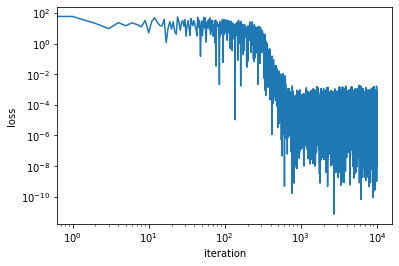

In [ ]:
w = torch.zeros(dimension, requires_grad=True)
b = torch.zeros(1, requires_grad=True)
param_groups = [{'params': [w], 'lr': 0.1}, {'params': [b], 'lr': 0.01}]
optimizer = SGD(param_groups, 0.10)

losses = []
for t in range(num_iter):
  optimizer.zero_grad()
  loss = loss_func(w, b, w_true, b_true)
  loss.backward()
  optimizer.step()

  losses.append(loss.item())

plt.plot(losses)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.xscale('log')
plt.yscale('log')
plt.show()

Remarks

1. What are these "`p`" values representing?

In class, we frequently consider a single parameter $w$ to describe the model we are training, so that $w$ would represent all the weights in a neural network for example. However, in practice usually models are specified in a more modular manner. For example, we could have a linear model with a bias as:
$$
\hat y = \langle A, x\rangle + B
$$
where $A\in \mathbb{R}^d$ is a weight vector and $B\in\mathbb{R}$ is a bias. For theoretical analyses, we might consider this model as parametrized by a single vector $w\in \mathbb{R}^{d+1}$, but when programming it is far simpler to have separate variables for $A$ and $B$. Just as in your previous programming assignment, the `A.grad` and `B.grad` variables will then be populated with  the partial derivatives of the overall loss with respect to $A$ and $B$. Thus, to implement a gradient based optimizer, we need to loop over all variables that were involved in specifying the model. `p` is the variable used to step through this loop, so in the linear model with bias example, `p` would take on both `A` and `B` as values.

2. What does `@torch.no_grad` do? 

This tells the pytorch not to record gradient operations for anything that happens inside the function, so it will not be able to compute derivatives of these operations. However, this is important to enable because some operations (like performing an update) inherently should not be differentiated, and pytorch will thrown an error if you do not explicitly tell it that you do not want to differentiate through this operation.

3. Why do we need `torch.enable_grad` when using the closure?

Computing the closure (closure is essentially a fancy name for "function") is an alternative to providing the gradient to the optimization step. Instead, the loss $\ell(w_t, z_t)$ is computed by the closure. However, the closure might need to compute some derivatives, so we turn on `torch.enable_grad`.

4. Why do we use `p.add_` as opposed to `p = p - lr*grad`?

All pytorch variables (and all python variables except for simple things like integers and chars for that matter) are essentially *pointers*. That is, `p` is a name for an area of computer memory that contains the data for some vector. This makes it fast to pass `p` around to various functions, but if we do `p = z`, this actually means that now `p` refers to the same memory location that `z` is referring to. This is a problem, because the original data has not been changed. `p.add_` instead will change the original data. If you are not familiar with this concept in programming, you may want to do some reading on pass-by-reference vs pass-by-value and pointers.





# PART 1: Per-Variable AdaGrad


## QUESTION 1 (10pt)

1. Fill out the class below to implement a version of SGD that sets the "adaptive" learning rate on a per-pytorch variable basis:
$$
\eta_t[p] = \frac{lr}{\sqrt{G_t[p]}}
$$
$lr$ (for "learning rate") is provided as input to the algorithm, $t$ is the current iteration count, and
$$
G_t[p] = \sum_{i=1}^t \|\nabla \ell(w_i, z_i)[p]\|^2
$$
where here $p$ indicates a pytorch variable object (which could be a high-dimensional vector), and $\nabla \ell(w_t, z_t)[p]$ indicates the partial derivative with respect to $p$ (i.e. the coordinates of the gradient corresponding to $p$).
If you are familiar with the AdaGrad update, note that this is NOT the same because AdaGrad uses a *per-coordinate* learning rate, while we use a *per-variable* learning rate. For very large models in which memory is at a premium, this kind of change can reduce the memory required by the optimizer while still preserving some of the adaptive properties of AdaGrad.

Read the `__init__` method carefully as it has changed slightly from the original `SGD` class above.

In [ ]:
class SGD_adaptive(Optimizer):
  def __init__(self, params, lr=1.0):
    super(SGD_adaptive, self).__init__(params, {'lr': lr})

    for group in self.param_groups:
      for p in group['params']:
        state = self.state[p]
        state['step'] = 0

        # make a dictionary entry for Gt. It is just a 1-D vector (a scalar).
        # device=p.device tells pytorch to allocate the memory for Gt on the 
        # same device (e.g. CPU or GPU) as the data for the variable p.
        state['Gt'] = torch.zeros(1, device=p.device)

  @torch.no_grad()
  def step(self, closure=None):
    loss = None
    if closure is not None:
      with torch.enable_grad():
        loss = closure()

    for group in self.param_groups:
      lr = group['lr']
      for p in group['params']:
        if p.grad is None:
          continue
        
        ####### YOUR CODE HERE ########
        self.state[p]['Gt'] += torch.linalg.norm(p.grad)
        self.state[p]['step'] += 1
        e_lr = lr/torch.sqrt(self.state[p]['Gt'])
        p.add_(p.grad, alpha=-e_lr.item())
        

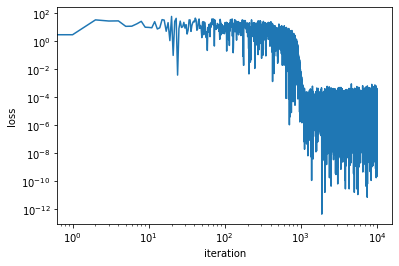

In [ ]:
w = torch.zeros(dimension, requires_grad=True)
b = torch.zeros(1, requires_grad=True)
optimizer = SGD_adaptive([w, b], 1.0)
losses = []
for t in range(num_iter):
  optimizer.zero_grad()
  loss = loss_func(w, b, w_true, b_true)
  loss.backward()
  optimizer.step()

  losses.append(loss.item())

plt.plot(losses)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.xscale('log')
plt.yscale('log')
plt.show()

See https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py for some similar example of how to set up the process below, from which much of this was copied.

In [ ]:
## These commands create two pytorch "DataLoader" objects, one for training
# data and one for testing data.
# A DataLoader object is essentially a list of training/testing examples with
# some extra code attached by pytorch that can send the data to GPUs.

# The following three commands produce a torchvision dataset object for both
# training and testing data on the CIFAR10 dataset, which is a dataset of images.
# these objects are like lists of vectors (the "transform" specifies a function
# that converts images to vectors).
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
CIFAR_train = torchvision.datasets.CIFAR10(root='CIFAR10/', train=True, download=True, transform=transform)
CIFAR_test = torchvision.datasets.CIFAR10(root='CIFAR10/', train=False, transform=transform)


# The next two lines produce the actual DataLoaders. The batch_size argument sets
# the batch size, so that the DataLoader will appear like a list [a,b,c...] where
# each entry of the list is a batch of batch_size examples. 
# Setting shuffle=True makes it so that when you start iterating over the examples
# in the DataLoader, it will first shuffle the order of the list.
trainloader = torch.utils.data.DataLoader(CIFAR_train, batch_size=16,
                                          shuffle=True)
testloader = torch.utils.data.DataLoader(CIFAR_test, batch_size=256,
                                          shuffle=True)

Files already downloaded and verified


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)


cuda:0


## QUESTION 2

Function `train_renset` implements the training loop. It loops over the entire dataset multiple time, and each pass is called an "epoch". At the beginning of each pass, the entire training data is shuffled and partitioned into mini-batches, and we will loop over every batch $i=1,\ldots,\lceil \frac{N}{b} \rceil$, where $N$ denotes the size of training data, and $b$ denote the batch size. 

In this problem, you will need to implement part of `train_resnet` inside the inner loop over mini-batches. 

### 2a (5pt)

In each iteration $i$, let $z_i=(x_i, y_i)$ be $i$-th data batch, where $x_i=(x_i^1,\ldots,x_i^b)$ is the list of features and $y_i=(y_i^1,\ldots,y_i^b)$ is the list of labels. You need to compute the cross entropy loss $\ell(w_i,z_i)$, plus an L2 regularization (otherwise known as "weight decay") term to generate the full loss function: $$\bar\ell(x_i, z_i) =\ell(w_i, z_i)+ \frac{\lambda}{2}\|w_i\|^2$$. In the code, $\lambda$ is stored in the variable `wd` (partly because `lambda` is a special keyword in python).

See [here](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html?highlight=loss#torch.nn.CrossEntropyLoss) for `torch.nn.CrossEntropyLoss`.

### 2b (5pt)

In this part, you need to call the optimizer and make a step w.r.t. the regularized loss $\bar\ell(w_i,z_i)$. *Hint: see the training loop for SGD as a reference*.

In [ ]:
## Please read the function signatures and doc string for "train_resnet" function.
# You do not need to otherwise understand how it works to do this homework. ##

def adjust_learning_rate(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

def train_resnet(optimizer, train_loader, device, lrs, wd=0.01, model=None):
  '''
  Trains a resnet model on CIFAR10 data.

  args:
    optimizer: optimizer class that will be instantiated inside this function.
    train_loader: pytorch DataLoader object that provides the training examples.
    device: pytorch device to use (e.g. a GPU).
    lrs: list of learning rates. The length of the list is the number of epochs
      to train for. At the start of the ith epoch, the 'lr' parameter of the
      optimizer will be set to lrs[i].
    wd: l2 regularization constant.
    model: can provide a preset pytorch model to train from a checkpoint. If 
      None, will instantiate a fresh resnet18 model.

  returns:
    the trained pytorch model object.
  '''

  if model is None:
    model = torchvision.models.resnet18(pretrained=False)
  model.to(device)


  # define \ell as the cross-entropy function.
  # this function as implemented in pytorch actually combines both the softmax
  # and the cross entropy function into one. As a result, it is
  # is non-negative, smooth, Lipschitz, and convex in its argument, which
  # are the predicted scores for various classes output by some model.
  # Note that this does NOT necessarily imply that it has these properties
  # with respect to the parameters of the model.
  cross_entropy_loss = torch.nn.CrossEntropyLoss()

  optimizer = SGD_adaptive(model.parameters(), lrs[0])

  num_epochs = len(lrs)

  average_loss = 0.0

  for epoch, lr in enumerate(lrs):
    # iterate over training set. One full pass over the training set is called
    # an "epoch". The number of epochs equals to the length of list 'lrs'.

    # manually set learning rate at the beginning of each epoch.
    adjust_learning_rate(optimizer, lr)

    # external progress bar library
    pbar = tqdm(enumerate(train_loader), total=len(train_loader))

    for it, data in pbar:
      # 'it' is index of example, 'data' is the example (e.g. z_i).
      # because shuffle=True when defining the trainloader,
      # the training set is shuffled after every complete pass.

      # unpack the example data: inputs is a batch of images,
      # labels is a batch of labels.
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)

      # pytorch will keep details from old gradients around in case you are going
      # to differentiate something else. We therefore need to delete this old
      # data before computing the loss so that we only have the gradient
      # for this iteration.
      optimizer.zero_grad()

      # compute labels from model. This will be a tensor of shape [B, C] where B is the 
      # batch size and C is the number of classes. Each row will contain scores for 
      # each class, where higher score indicates that the model believe the corresponding
      # class is correct.
      predicted_labels = model.forward(inputs)


      # get the list of parameters in the neural network. This list will
      # contain all the weight and bias tensors.
      parameters = list(model.parameters())
      
      ### YOUR CODE HERE (2a) ###
      # In this part, you need to implement the regularized loss \ell(w_i,z_i) + wd/2 * ||w_i||^2.
      # You should name your final result as 'regularized_loss'.
      # You may wish to use the `cross_entropy_loss` layer defined above. See the
      # docs for the CrossEntropyLoss pytorch function to see how to apply it.

      pl = 0
      for par in parameters:
          pl =pl +  wd/2*torch.linalg.norm(par.data) ** 2
      regularized_loss = cross_entropy_loss(predicted_labels, labels) + pl


      ### YOUR CODE HERE (2b) ###
      # In this part, you need to call the optimizer and make a step
      # w.r.t. the regularized_loss.
      # loss = regularized_loss
      regularized_loss.backward()
      optimizer.step()
      #raise NotImplementedError

      # update average loss
      average_loss += (loss.item() - average_loss)/(it+1)

      pbar.set_description(f"epoch {epoch + 1} iter {it + 1}: train loss {average_loss:.5f}.")

    average_loss = 0.0

  print('\nFinished Training')

  return model


In [ ]:
## Train the model for 3 epochs using a learning rate of 0.1 in each epoch.
## If this fails, you probably have a significant bug in your SGD code.
## Each epoch should take < 5 minutes, for a total of at most 15 minutes.
trained_model = train_resnet(SGD_adaptive, trainloader, device, lrs=[0.1, 0.1, 0.1])

epoch 3 iter 3125: train loss 0.00000.: 100%|██████████| 3125/3125 [01:23<00:00, 37.46it/s]


Finished Training


In [ ]:
# These functions take input a trained model and return either the train or
# test accuracy.
def get_train_accuracy(trained_model):
  correct = 0
  total = 0
  with torch.no_grad():
    trainloader = torch.utils.data.DataLoader(CIFAR_train, batch_size=256, num_workers=2)
    for data in trainloader:
      images, labels = data
      images = images.to(device)
      labels = labels.to(device)
      outputs = trained_model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  return 100 * correct / total

def get_test_accuracy(trained_model):
  correct = 0
  total = 0
  with torch.no_grad():
    testloader = torch.utils.data.DataLoader(CIFAR_test, batch_size=256, num_workers=2)
    for data in testloader:
      images, labels = data
      images = images.to(device)
      labels = labels.to(device)
      outputs = trained_model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  return 100 * correct / total

In [ ]:
## Print the test accuracy. The test accuracy should be ~50% because the learning
## rate of 0.1 used earlier is not a good learning rate.
test_accuracy = get_test_accuracy(trained_model)
print("test accuracy percentage: ", test_accuracy)

test accuracy percentage:  54.65


## QUESTION 3

### 3a (10pt)

In the previous section, we choose the learning rates to be 0.1 in all three epochs, which leads to ~50% test accuracy after 3 epochs of training. In this part, tune the learning rate schedules to get the best test performance at batch size 16. You should get close to or better than 70%.

Note: 
With batch size 16, each epoch should take < 5 minutes (for a total of 15 minutes).

Hint:
- A common practice for tuning learning rates is grid search. You can make a list of candidates (typically in log scale, e.g., `[1,0.1,0.01,0.001]`) and then choose the best learning rate among them.
- For this problem, you can assume that the learning rates for later epochs is always less than or equal to the learning rates for earlier epochs, i.e., $\eta_{t+1} \le \eta_t$. You can also assume that $\eta_{t+1} \geq \eta_t/10$. These are also common choices in practice.

In [ ]:
# This function returns a DataLoader object for the training set that uses
# the provided argument as a batch size.
def get_trainloader(batch_size):
  trainloader = torch.utils.data.DataLoader(
      CIFAR_train, batch_size=batch_size, shuffle=True)
  return trainloader

In [ ]:
# Optional utils functions for saving and loading models
def save_model(model, model_name):
    torch.save(model.state_dict(), f'{model_name}.pth')

def load_model(model_name):
    state_dict = torch.load(f'{model_name}.pth')
    model = torchvision.models.resnet18(pretrained=False)
    model.load_state_dict(state_dict)
    return model

In [ ]:
### TUNE LEARNING RATE SCHEDULE HERE ###
# all you need to do is fill out lrs with appropriate values,
# the difficulty is finding those values.
lrs = [0.1, 0.01, 0.001]

In [ ]:
batch_size_list = [16, 64, 256, 1024]
trained_models = {16: None, 64: None, 256: None, 1024: None}

trainloader = get_trainloader(batch_size=16)
trained_models[16] = train_resnet(
    SGD_adaptive, trainloader, device, lrs=lrs)

# Print the test accuracy.
# Your test accuracy should be close to or better than 70%.
test_accuracy = get_test_accuracy(trained_models[16])
print("[batch size %d] test accuracy: %d" % (16, test_accuracy))

epoch 3 iter 3125: train loss 0.00000.: 100%|██████████| 3125/3125 [01:25<00:00, 36.66it/s]


Finished Training


[batch size 16] test accuracy: 66


In [ ]:
# Print the test accuracy.
# Your test accuracy should be close to or better than 70%.
test_accuracy = get_test_accuracy(trained_models[16])
print("[batch size %d] test accuracy: %d" % (16, test_accuracy))

[batch size 16] test accuracy: 66


### 3b (10pt)

For each batch size in `[16, 64, 256, 1024]`, we populate the dictionary `trained_models` with a model trained using that batch size for three epochs using `train_resnet`, the `SGD_adaptive` algorithm, and the learning rates you tuned in 2a.

When you run the code, you should observe that for larger batch size, (1) the performance is worse and (2) the running time is shorter. Briefly explain the two observations.

**Answer:**

1. (Performance)
When batch size increase, accuracy will decrease. When batch size increase, opmizer will update fewer times in each epoch, the model will not converge to the ideal point under same epoch number and learning rate.

2. (Running time)
When batch size increase, running time will decrease because GPU is good to handle muti same processes in the same time.

In [ ]:
## With batch size 16, each epoch should take < 5 minutes (for a total of 15 minutes).
## With batch size 64, < 2 minutes.
## With batch size 256 and 1024, < 1 minute.
for batch_size in batch_size_list[1:]:
    trainloader = get_trainloader(batch_size)
    trained_models[batch_size] = train_resnet(
        SGD_adaptive, trainloader, device, lrs=lrs)

epoch 3 iter 782: train loss 0.00000.: 100%|██████████| 782/782 [00:33<00:00, 23.38it/s]



Finished Training


epoch 3 iter 196: train loss 0.00000.: 100%|██████████| 196/196 [00:19<00:00, 10.10it/s]



Finished Training


epoch 3 iter 49: train loss 0.00000.: 100%|██████████| 49/49 [00:16<00:00,  2.94it/s]


Finished Training


In [ ]:
for batch_size in batch_size_list:
  test_accuracy = get_test_accuracy(trained_models[batch_size])
  train_accuracy = get_train_accuracy(trained_models[batch_size])
  print("[batch size %d] train accuracy: %d , test accuracy: %d" % (batch_size, train_accuracy, test_accuracy))

[batch size 16] train accuracy: 70 , test accuracy: 66
[batch size 64] train accuracy: 71 , test accuracy: 64
[batch size 256] train accuracy: 70 , test accuracy: 60
[batch size 1024] train accuracy: 59 , test accuracy: 53


# PART 2: AdamW and Norm-scaling

The next part of this homework assignment investigates implementing some variants of Adam. We will be testing your optimizers on a simplified implementation of [GPT](https://github.com/openai/gpt-3) based on the [minGPT](https://github.com/karpathy/minGPT) repository by Andrej Karpathy. This is a model that takes as input a sequence of 128 characters from a text file and attempts to predict the next character. This can be used to generate novel text by starting with a seed text string, and then repeatedly using the model to generate another character.


# Tips
* You will need a GPU for this assignment. When using google colab, go to runtime->change runtime type and make sure that the type is set to GPU.

* You may decrease the number of training epochs while debugging, but please set it back to 20 and run again before submission.

* Study the provided AdaGrad implementation closely, it introduces a few pytorch functions that may be useful. You should check the documentation for these functions to see what they do.

* You may occasionally need to restart the runtime (runtime->restart runtime). Sometimes the GPUs don't release memory properly, and sometimes the progress bars get a little messed up.

## QUESTION 4a (10pt)

Implement the [AdamW](https://openreview.net/pdf?id=Bkg6RiCqY7) update *without* using the debiasing terms. AdamW performs the following (**per-coordinate**) update:

$$
w_{t+1} = w_t - \eta_t\left(\frac{\hat m_t}{\sqrt{\hat v_t} +\epsilon} + \lambda w_t\right)
$$
where $\hat m_t$ and $\hat v_t$ are generated the same way as in the standard [Adam](https://openreview.net/pdf?id=Bkg6RiCqY7) update, and $\lambda$ is an extra "weight decay" parameter provided to the optimizer and $\eta_t$ is the learning rate parameter provided to the optimizer by the user.

Ordinarily, "weight decay" is another word for L2 regularization. That is, the loss is modified to:
$$
\mathcal{L}(w) + \frac{\lambda}{2}\|w\|^2
$$
This means that we could implement weight decay by changing the gradient to $\nabla \mathcal{L}(w) + \lambda w$. The idea behind AdamW is that the weight-decay term is in some sense "well-understood" and should not be included in the $v_t$ and $A_t$ statistics that are being used to understand the more mysterious loss surface $\mathcal{L}(w)$. See the linked paper for more details and full pseudocode.

In your implementation, you should use the raw $m_t$ and $v_t$ values without applying the debiasing terms discussed in the papers and class. That is, you should implement the update:

$$
w_{t+1} = w_t - \eta_t\left(\frac{m_t}{\sqrt{v_t} +\epsilon} + \lambda w_t\right)
$$
where $m_t$ and $v_t$ are as defined in the [linked paper](https://openreview.net/pdf?id=Bkg6RiCqY7).


## QUESTION 4b (10pt)

Upgrade your debias-free AdamW implementation to use the `use_norm_scaling` argument of the `__init__` method. When this argument is `True`, you should scale the learning rate by the norm of the weights *for the given pytorch variable*. That is, for each variable $p$ you will replace the learning rate $\eta_t$ at time $t$ with $\|p\|\eta_t$ in the update:
$$
w_{t+1}[i] = w_t[i] - \|w_t\|_2\eta_t\left(\frac{m_t[i]}{\sqrt{v_t[i]} +\epsilon} + \lambda w_t[i]\right)
$$
When the `use_norm_scaling` argument is false, simply perform the update from question 1a.

This learning rate heuristic is inspired by a similar proposal for use with normalized updates in the [LARS](https://arxiv.org/abs/1708.03888) optimizer.

In [ ]:

class AdamW_bias(Optimizer):
  def __init__(self, params, lr=1.0, betas=(0.9,0.999), use_norm_scaling=False):
    super(AdamW_bias, self).__init__(params, {'lr': lr, 'beta1': betas[0], 'beta2': betas[1], 'weight_decay': 0.0})

    self.use_norm_scaling = use_norm_scaling

    for group in self.param_groups:
      for p in group['params']:
        ## YOUR CODE HERE ##
        state = self.state[p]
        state['step'] = 0
        d = len(p)
        state['m'] = torch.zeros(p.shape, device = p.device)
        state['v'] = torch.zeros(p.shape, device = p.device) 
        # raise NotImplementedError

  @torch.no_grad()
  def step(self, closure=None):
    # in this class, and also usually in practice, closure will always be None.
    loss = None
    epsilon = 1e-8
    if closure is not None:
      with torch.enable_grad():
        loss = closure()
      
    ## YOUR CODE HERE ##
    for group in self.param_groups:
      lr = group['lr']
      beta1 = group['beta1']
      beta2 = group['beta2']
      weight_decay = group['weight_decay']
      for p in group['params']:
        if p.grad is None:
          continue
        state = self.state[p]
        g = p.grad
        state['step'] += 1
        state['m'] = beta1 * state['m'] + (1 - beta1) * g
        state['v'] = beta2 * state['v'] + (1 - beta2) * g**2
        if self.use_norm_scaling:
          p.add_(-lr*(state['m']/(torch.sqrt(state['v'])+epsilon) + weight_decay*p.data), alpha = torch.norm(p))
        else:
          p.add_(-lr*(state['m']/(torch.sqrt(state['v'])+epsilon) + weight_decay*p.data))



In [ ]:
# a simple bug testing for AdamW implementation for part A *only*.
# your outputs should be the same as the reference function.
# the internal state will likely be the same as well, but may be different if your
# implementation is very different in some way.

d = 2
lr = 0.1
beta1 = 0.9
beta2 = 0.99
use_norm_scaling = True
epsilon = 1e-8

def log_state(optim):
    state = optim.state
    for group in optim.param_groups:
        for p in group['params']:
            print(f'parameter: {p.data}, gradient: {p.grad}')
            print(f'states: {state[p]}')

# reference function
def reference(p, m, v, t, g):
    m = beta1*m + (1-beta1)*g
    v = beta2*v + (1-beta2)*g**2
    est = m / (epsilon + torch.sqrt(v))
    if use_norm_scaling:
        p = p - lr*torch.norm(p) * est
    else:
        p = p - lr * est
    print(f'parameter: {p}')
    print(f"states: {{'step': {t}, 'mt': {m}, 'vt': {v}}}")
    return p, m, v, t+1

p = torch.ones((d,))
optim = AdamW_bias([p], lr=lr, betas=(beta1, beta2), 
                   use_norm_scaling=use_norm_scaling)

p_ref = torch.ones((d,))
m = torch.zeros((d,))
v = torch.zeros((d,))
t = 1

for i in range(3):
    print(f"\nround {i+1}:")
    print("- your outputs:")
    p.grad = 10 * torch.rand((d,)) - 5
    optim.step()
    log_state(optim)
    print("- reference outputs:")
    p_ref, m, v, t = reference(p_ref, m, v, t, p.grad)


round 1:
- your outputs:
parameter: tensor([1.1414, 1.1414]), gradient: tensor([-3.4952, -0.6046])
states: {'step': 1, 'm': tensor([-0.3495, -0.0605]), 'v': tensor([0.1222, 0.0037])}
- reference outputs:
parameter: tensor([1.1414, 1.1414])
states: {'step': 1, 'mt': tensor([-0.3495, -0.0605]), 'vt': tensor([0.1222, 0.0037])}

round 2:
- your outputs:
parameter: tensor([1.2077, 1.0571]), gradient: tensor([1.5784, 1.2855])
states: {'step': 2, 'm': tensor([-0.1567,  0.0741]), 'v': tensor([0.1459, 0.0201])}
- reference outputs:
parameter: tensor([1.2077, 1.0571])
states: {'step': 2, 'mt': tensor([-0.1567,  0.0741]), 'vt': tensor([0.1459, 0.0201])}

round 3:
- your outputs:
parameter: tensor([1.3430, 0.8797]), gradient: tensor([-2.3634,  2.8063])
states: {'step': 3, 'm': tensor([-0.3774,  0.3474]), 'v': tensor([0.2003, 0.0987])}
- reference outputs:
parameter: tensor([1.3430, 0.8797])
states: {'step': 3, 'mt': tensor([-0.3774,  0.3474]), 'vt': tensor([0.2003, 0.0987])}


The following cells tests your optimizer on the min-GPT model.

In [ ]:
# the "block size" is the number of characters the model takes as input.
# in this case, it can look at up to 128 characters when predicting the next
# character.
block_size = 128 # spatial extent of the model for its context

# For our training set, we will use the text of the first four Harry Potter books.
text = open("J. K. Rowling - Harry Potter 1 - Sorcerer's Stone.txt", 'rb').read()
text += open('J. K. Rowling - Harry Potter 2 - The Chamber Of Secrets.txt', 'rb').read()
text += open('J. K. Rowling - Harry Potter 3 - Prisoner of Azkaban.txt', 'rb').read()
text += open('J. K. Rowling - Harry Potter 4 - The Goblet of Fire.txt', 'rb').read()

# text = open('input.txt', 'r').read() # don't worry we won't run out of file handles
train_dataset = CharDataset(text, block_size) # one line of poem is roughly 50 characters

data has 2652652 characters, 91 unique.


In [ ]:
# generate the configuration for the model. These parameters specify
# the neural network architecture we will be using. It is not necessary
# to understand this model architecture.
mconf = GPTConfig(train_dataset.vocab_size, train_dataset.block_size,
                  n_layer=8, n_head=8, n_embd=128)

In [ ]:
# generate training configurations for each of the optimizers. We will be testing
# adam (official pytorch implementation)
# adamw (official pytorch implementation)
# your optimizer both with and without the norm_scaling flag set.
def adamw_bias_factory(params, lr, betas):
  return AdamW_bias(params, lr, betas)

def adamw_bias_norm_scaling_factory(params, lr, betas):
  return AdamW_bias(params, lr, betas, use_norm_scaling=True)

optimizers = {
    'adam': torch.optim.Adam, 
    'adamw': torch.optim.AdamW, 
    'adamw_bias': adamw_bias_factory, 
    'adamw_bias_norm_scaling': adamw_bias_norm_scaling_factory
  }

training_configs = {}

for name, opt in optimizers.items():
# construct a training config: this sets the learning rate, batch size, number 
# of epochs ect for each optimizer. warmup_tokens and final_tokens are parameters
# used to setup a warm-up and decay learning rate scheduler.
  training_configs[name] = TrainerConfig(max_epochs=5, batch_size=256, learning_rate=6e-4, optimizer=opt,
                        lr_decay=True, warmup_tokens=512*20, final_tokens=200*len(train_dataset)*block_size,
                        num_workers=2)
torch.cuda.empty_cache()

In [ ]:
import gc

In [ ]:
gc.collect()

298

In [ ]:
# train a model on each optimizer, keeping track of the best-performing one.
# each epoch should take less than 2 minutes to train, for a total of at most
# 4 algorithms * 5 epochs / algorithm * 2 minutes / epoch = 40 minutes training time
losses = {}
min_loss = float('inf')
best_model = None
best_optimizer = None
for name, tconf in training_configs.items():
  print("training new model with optimizer: {}".format(name))
  model = GPT(mconf)
  trainer = Trainer(model, train_dataset, None, tconf)
  train_loss = trainer.train()
  losses[name] = train_loss
  train_dataset = CharDataset(text, block_size)
  print("final epoch train loss: {}".format(train_loss))
  if train_loss < min_loss:
    best_optimizer = name
    min_loss = train_loss

print("best optimizer: {} with loss: {}".format(best_optimizer, min_loss))

training new model with optimizer: adam


epoch 1 iter 80: train loss 2.67471. lr 5.999633e-04: 100%|██████████| 81/81 [00:24<00:00,  3.24it/s]
epoch 2 iter 80: train loss 2.61293. lr 5.998525e-04: 100%|██████████| 81/81 [00:25<00:00,  3.16it/s]
epoch 3 iter 80: train loss 2.62358. lr 5.996678e-04: 100%|██████████| 81/81 [00:25<00:00,  3.18it/s]
epoch 4 iter 80: train loss 2.60039. lr 5.994091e-04: 100%|██████████| 81/81 [00:25<00:00,  3.15it/s]
epoch 5 iter 80: train loss 2.61173. lr 5.990766e-04: 100%|██████████| 81/81 [00:26<00:00,  3.10it/s]


data has 2652652 characters, 91 unique.
final epoch train loss: 2.6159590026478696
training new model with optimizer: adamw


epoch 1 iter 80: train loss 2.53138. lr 5.999633e-04: 100%|██████████| 81/81 [00:26<00:00,  3.09it/s]
epoch 2 iter 80: train loss 2.40038. lr 5.998525e-04: 100%|██████████| 81/81 [00:26<00:00,  3.09it/s]
epoch 3 iter 80: train loss 2.24619. lr 5.996678e-04: 100%|██████████| 81/81 [00:26<00:00,  3.10it/s]
epoch 4 iter 80: train loss 2.14337. lr 5.994091e-04: 100%|██████████| 81/81 [00:26<00:00,  3.08it/s]
epoch 5 iter 80: train loss 1.93592. lr 5.990766e-04: 100%|██████████| 81/81 [00:26<00:00,  3.09it/s]


data has 2652652 characters, 91 unique.
final epoch train loss: 2.028879724902871
training new model with optimizer: adamw_bias


epoch 1 iter 80: train loss 2.49404. lr 5.999633e-04: 100%|██████████| 81/81 [00:26<00:00,  3.07it/s]
epoch 2 iter 80: train loss 2.39042. lr 5.998525e-04: 100%|██████████| 81/81 [00:26<00:00,  3.06it/s]
epoch 3 iter 80: train loss 2.28602. lr 5.996678e-04: 100%|██████████| 81/81 [00:26<00:00,  3.07it/s]
epoch 4 iter 80: train loss 2.10476. lr 5.994091e-04: 100%|██████████| 81/81 [00:26<00:00,  3.05it/s]
epoch 5 iter 80: train loss 1.94891. lr 5.990766e-04: 100%|██████████| 81/81 [00:26<00:00,  3.06it/s]


data has 2652652 characters, 91 unique.
final epoch train loss: 2.01365422319483
training new model with optimizer: adamw_bias_norm_scaling


epoch 1 iter 80: train loss 2.50003. lr 5.999633e-04: 100%|██████████| 81/81 [00:27<00:00,  2.98it/s]
epoch 2 iter 80: train loss 2.38791. lr 5.998525e-04: 100%|██████████| 81/81 [00:27<00:00,  2.99it/s]
epoch 3 iter 80: train loss 2.26936. lr 5.996678e-04: 100%|██████████| 81/81 [00:27<00:00,  2.99it/s]
epoch 4 iter 80: train loss 1.97803. lr 5.994091e-04: 100%|██████████| 81/81 [00:27<00:00,  2.99it/s]
epoch 5 iter 80: train loss 1.80661. lr 5.990766e-04: 100%|██████████| 81/81 [00:27<00:00,  2.99it/s]


data has 2652652 characters, 91 unique.
final epoch train loss: 1.8888056660875856
best optimizer: adamw_bias_norm_scaling with loss: 1.8888056660875856


In [ ]:
## Now that we have identified a best optimizer, let us train for a longer amount of time (another 40 minutes):
long_train_conf = TrainerConfig(max_epochs=20, batch_size=256, learning_rate=6e-4, optimizer=optimizers[best_optimizer],
                        lr_decay=True, warmup_tokens=512*20, final_tokens=200*len(train_dataset)*block_size,
                        num_workers=2)
print("training new model with optimizer: {}".format(name))
best_model = GPT(mconf)
train_dataset = CharDataset(text, block_size)
trainer = Trainer(best_model, train_dataset, None, long_train_conf)
train_loss = trainer.train()
print("final epoch train loss: {}".format(train_loss))

training new model with optimizer: adamw_bias_norm_scaling
data has 2652652 characters, 91 unique.


epoch 1 iter 80: train loss 2.47840. lr 5.999633e-04: 100%|██████████| 81/81 [00:27<00:00,  2.99it/s]
epoch 2 iter 80: train loss 2.40797. lr 5.998525e-04: 100%|██████████| 81/81 [00:27<00:00,  2.95it/s]
epoch 3 iter 80: train loss 2.26146. lr 5.996678e-04: 100%|██████████| 81/81 [00:27<00:00,  2.99it/s]
epoch 4 iter 80: train loss 1.99882. lr 5.994091e-04: 100%|██████████| 81/81 [00:27<00:00,  2.99it/s]
epoch 5 iter 80: train loss 1.74424. lr 5.990766e-04: 100%|██████████| 81/81 [00:27<00:00,  2.99it/s]
epoch 6 iter 80: train loss 1.59826. lr 5.986703e-04: 100%|██████████| 81/81 [00:27<00:00,  2.99it/s]
epoch 7 iter 80: train loss 1.53731. lr 5.981902e-04: 100%|██████████| 81/81 [00:26<00:00,  3.00it/s]
epoch 8 iter 80: train loss 1.52006. lr 5.976366e-04: 100%|██████████| 81/81 [00:27<00:00,  2.99it/s]
epoch 9 iter 80: train loss 1.49131. lr 5.970096e-04: 100%|██████████| 81/81 [00:27<00:00,  2.97it/s]
epoch 10 iter 80: train loss 1.51333. lr 5.963092e-04: 100%|██████████| 81/81 [00:

final epoch train loss: 1.3787673387998416


In [ ]:
# alright, sample some harry potter at the character level, starting from the seed
# "Harry opened the door, and"
# Note, this model is not advanced enough to learn how to actualy write sentences
# that makes sense, but it CAN learn to write complete words and certain names.
# With longer training times, bigger models, and more data, it is possible to
# achieve truly amazing results!

context = [ord(c) for c in "Harry opened the door, and"]
x = torch.tensor([train_dataset.stoi[s] for s in context], dtype=torch.long)[None,...].to(trainer.device)
y = sample(best_model, x, 2000, temperature=0.9, sample=True, top_k=5)[0]
completion = ''.join([chr(train_dataset.itos[int(i)]) for i in y])
print(completion)

Harry opened the door, and her followed in the floor. Harry had botten a living to the windows.  "It was a large would be a seconder."
"If you will be something in the top of the school beam."
"Harry," said Fred, turning the sight as though he was looking and speaking as though to the wall, though they were doing to do, the bed of sign of the sight white face was their hour feets.
"Have to deep to have to been a serious time," said Denath Eater Bertha Couldre Cedric.

"Won't be to the sine of the station, to have to do in the table."

"I took you a still boys there and to stell you and wanted to them," said Ron, turning
thisk abrupt and left into the wand, whose was an owls.

The window had been told
the time of the way.

There was thinging to the stops of the taile soft.
		A still table with three, with a look,

	The Dark Ark Seamus Cream and Cristered, who was the castle with a score over the table
		Harry had never shouted himself open, the watch the first completed to sit a stop an